# <center> TP3 : Bootstrap pour les séries temporelles <center>
Antoine GRELETY

Vincent LE MEUR

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import math
import scipy as sc
from scipy.stats import norm
import statsmodels.genmod.generalized_linear_model as st
from matplotlib import pyplot as plt
import statsmodels.tsa.ar_model as armodel
import statsmodels.tsa.stattools as stat_ts
import statsmodels.tsa.arima_model as arima

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Exercice 1

#### 1.Bootstraping ma1 et ar1

In [2]:
def AR_sim(p,phis,epsilon):
    n = len(epsilon)
    if (len(phis)!=p) :
        print("le vecteur de paramètres n'a pas la bonne dimension ")
    X = np.zeros(n)
    for j in np.arange((p),(n)):
        X[j] = -np.dot(phis,X[(j-p):(j)]) +  epsilon[j]
    return(X[(p):(n)])

def MA_sim(q,psis,epsilon):
    n = len(epsilon)
    if (len(psis)!=q):
        print("le vecteur de paramètres n'a pas la bonne dimension")
    X = np.zeros(n)
    for j in np.arange((q+1),(n)):
        X[j] =  epsilon[j] + np.dot(psis,epsilon[(j-q):(j)])
    return(X[(q+1):(n)])

In [3]:
# Fonction créant B Séries bootstrapés i.i.d
def sample_iid(ar1,B):
    list_B=[]
    n=len(ar1)
    for k in range((B)):
        ind=npr.randint(0,n,n)
        sample=ar1[ind]
        list_B.append(sample)
    return(list_B)

In [4]:
# Mise en place de l'AR(1)
n=200
epsilon = np.random.exponential(1,n)-1
phis=np.array([-0.6])
p=1
ar1 = AR_sim(p,phis,epsilon)

In [5]:
# Mise en place du MA(1)
n=200
epsilon = np.random.exponential(1,n)-1
q=1
psis=np.array([0.5])
ma1=MA_sim(q,psis,epsilon)

In [6]:
B=100
list_ar1_boot = sample_iid(ar1,B)
list_ma1_boot = sample_iid(ma1,B)

#### 2.Représentation des séries

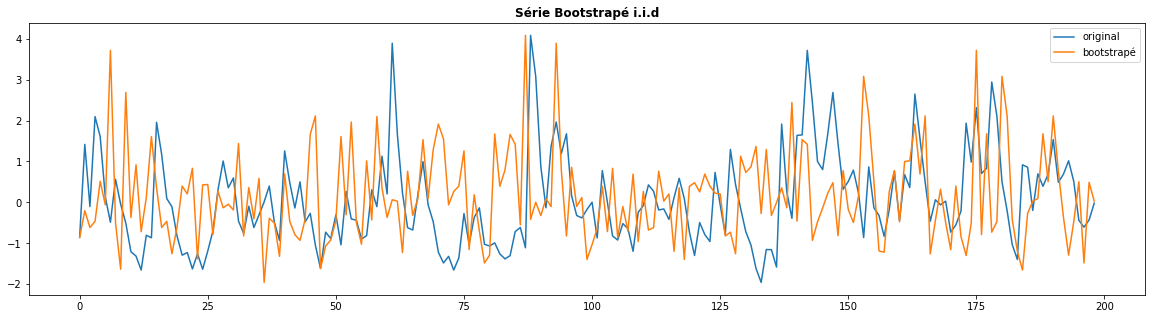

In [7]:
plt.figure(figsize=(20,5))
plt.title("Série Bootstrapé i.i.d",fontweight='bold')
plt.plot(ar1)
plt.plot(list_ar1_boot[0])
plt.legend(['original','bootstrapé'])
plt.show()

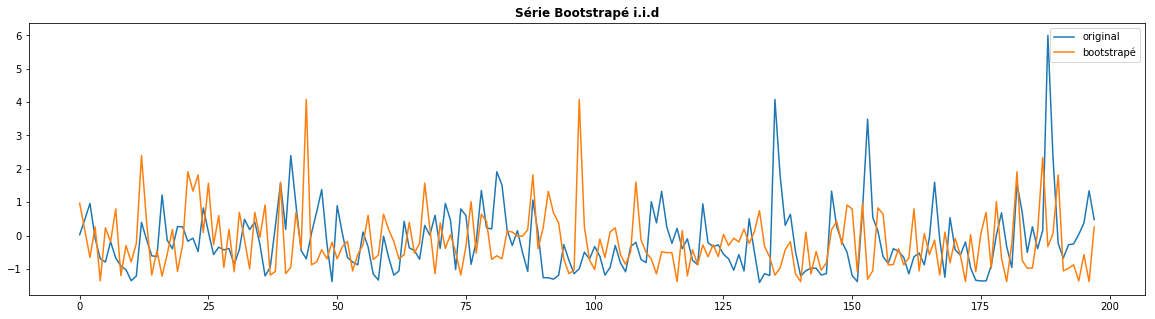

In [8]:
plt.figure(figsize=(20,5))
plt.title("Série Bootstrapé i.i.d",fontweight='bold')
plt.plot(ma1)
plt.plot(list_ma1_boot[0])
plt.legend(['original','bootstrapé'])
plt.show()

#### 3. Limites de la méthode

Les échantillons bootstrapés n'ont pas la même distribution par rapport à l'échantillon initial. Le bootstraping classique ne suit donc pas le même processus aléatoire.

### Exercice 2

In [10]:
n=200
epsilon = np.random.exponential(1,n)-1
p=2
phis=npr.uniform(0,0.1,size=p)
ar1 = AR_sim(p,phis,epsilon)

In [9]:
def bootstrap_sieve(serie,B=100):
    serie_model = armodel.AR(serie)
    p=serie_model.select_order(maxlag=10,ic='aic')
    fitted_serie=serie_model.fit(maxlag=p)
    fitted_values_serie = fitted_serie.fittedvalues
    res_serie = fitted_serie.resid
    res_serie = res_serie - 1/(n-p)*np.sum([res_serie[i] for i in np.arange(0,n-(p+2))]) #recentre les résidus
    phi=fitted_serie.params[range(1,len(fitted_serie.params))]  #on exclue l'intercept
    Boots_list=[]
    for b in range(B):
        ind=npr.randint(p+1,len(serie)-(p+1),1)
        Xboot=[]
        for t in range(p+1,len(serie)-(p+1)):
            X=ar1[range(t-p,t)]
            Xboot.append(np.dot(phi,X.T)+fitted_serie.params[0]+res_serie[ind])
        Xboot = np.array(Xboot).flatten()
        Boots_list.append(Xboot)
    return(Boots_list)

#### 1. Estime $\hat{p}_{n}$ et les coef associés

In [12]:
ar1_model = armodel.AR(ar1)
p=ar1_model.select_order(maxlag=10,ic='aic')
print("Estimation de p_n: ",p)

fitted_ar1=ar1_model.fit(maxlag=p)
fitted_values_ar = fitted_ar1.fittedvalues

Estimation de p_n:  10


#### 2. Estime residus

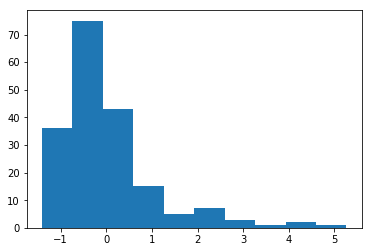

In [13]:
res_ar = fitted_ar1.resid
#recentre les résidus
res_ar = res_ar - 1/(n-p)*np.sum([res_ar[i] for i in np.arange(0,n-(p+2))])
plt.hist(res_ar)
plt.show()

On vérifie que les résidus sont bien centrés en 0

In [14]:
print(np.mean(res_ar))

8.267618268485208e-18


#### 3. Reconstruction de l'AR(p) process

In [15]:
B=100
phi=fitted_ar1.params[range(1,len(fitted_ar1.params))]  #on exclue l'intercept
Boots_list=[]
for b in range(B):
    #print(b)
    ind=npr.randint(p+1,len(ar1)-(p+1),1)
    Xboot=[]
    for t in range(p+1,len(ar1)-(p+1)):
        X=ar1[range(t-p,t)]
        Xboot.append(np.dot(phi,X.T)+fitted_ar1.params[0]+res_ar[ind])
    Boots_list.append(Xboot)

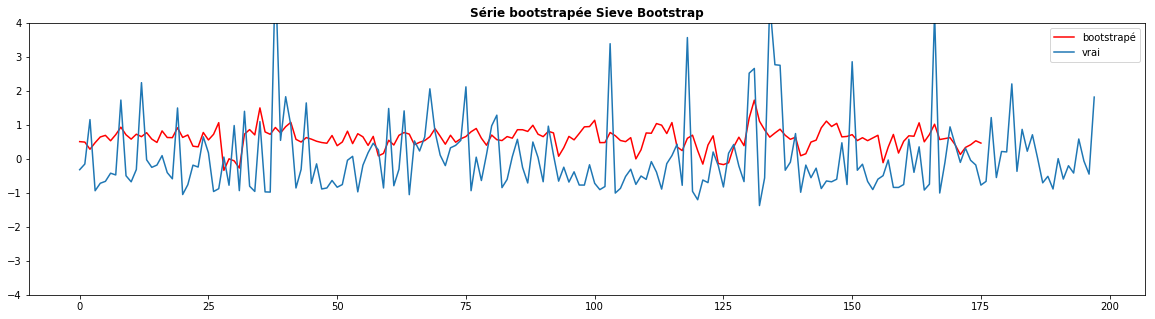

In [16]:
plt.figure(figsize=(20,5))
plt.title('Série bootstrapée Sieve Bootstrap',fontweight='bold')
plt.plot(Boots_list[0],color='red')
plt.plot(ar1)
plt.legend(['bootstrapé','vrai'])
plt.ylim(-4,4)
plt.show()

#### 2. Limites de la méthode

La série bootstrapée semble suivre les faibles variations de la série initiale mais semble en moyenne biaisée et capture difficilement les grands écarts par rapport à la moyenne.

### Exercice 3

In [10]:
def bootstrap_block(l,serie,B=100):
    # 1. et 2. Circulariser la série et définir l, N
    N=int(np.floor(n/l))
    #circularise la série
    X_circle = np.zeros(N*n)
    t=0
    for i in range(N*n):
        X_circle[i] = serie[t]
        t=t+1
        if(t==len(serie)):
            t=0
    # Etape 3: bootstraping
    Boots_list_block=[]
    for b in range(B):
        concat_X=[]
        for j in range(N):
            #(a) tire avec remise
            v_bk = npr.randint(0,N,1)
            #(b) crée des blocs
            X_vb = X_circle[np.arange(v_bk,v_bk+l)]
            concat_X.append(X_vb)
        concat_X=np.array(concat_X).flatten()
        Boots_list_block.append(concat_X)
    return(Boots_list_block)

In [18]:
Boots_list_block = bootstrap_block(l=5,serie=ma1)

In [11]:
plt.figure(figsize=(20,5))
plt.title('Série bootstrapée Block Bootstrap in Kunsch',fontweight='bold')
plt.plot(Boots_list_block[1],color='red')
plt.plot(ma1)
plt.legend(['bootstrapé','vrai'])

plt.show()

NameError: name 'Boots_list_block' is not defined

#### Limites de la méthode

Contrairement à la méthode précédente, cette série semble bien capturer l'amplitude de la série originale. Cependant, cette méthode dépend d'un découpage arbitraire en blocs de taille l. Ce type de découpage risque d'interférer avec les périodes de saisonalité.

### Exercice 4

In [12]:
def bootstrap_PR(l,serie,B=100):
    N=int(np.floor(n/l))
    #circularise la série
    X_circle = np.zeros(N*n)
    t=0
    for i in range(N*n):
        X_circle[i] = serie[t]
        t=t+1
        if(t==len(serie)):
            t=0
    Boots_list_PR=[]
    for b in range(B):
        concat_X=[]
        for j in range(N):
            #(a) tire avec remise
            v_bk = ind=npr.randint(0,N,1)
            #(b) crée des blocs
            l_geom = npr.geometric(1/l)
            while l_geom > n-1:
                l_geom = npr.geometric(1/l)
            X_vb = list(X_circle[np.arange(v_bk,v_bk+l_geom)])
            concat_X=concat_X+X_vb
        #concat_X=np.array(concat_X).flatten()
        Boots_list_PR.append(concat_X)
    return(Boots_list_PR)

In [21]:
Boots_list_PR = bootstrap_PR(l=5,serie=ma1)

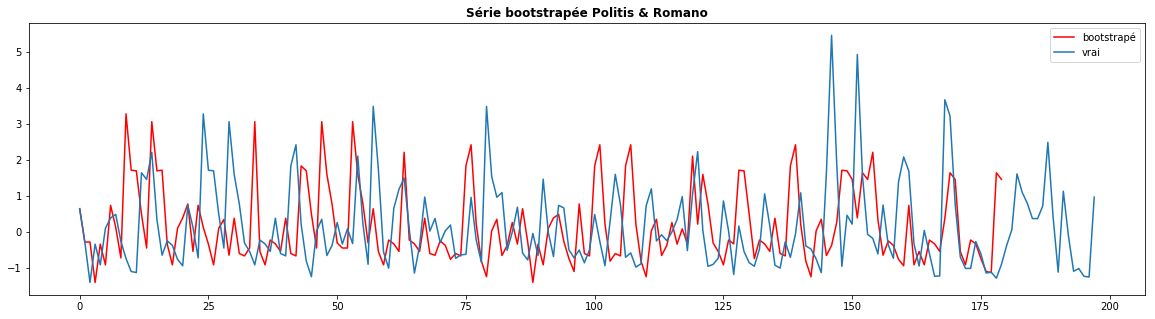

In [22]:
plt.figure(figsize=(20,5))
plt.title('Série bootstrapée Politis & Romano',fontweight='bold')
plt.plot(Boots_list_PR[2],color='red')
plt.plot(ma1)
plt.legend(['bootstrapé','vrai'])
plt.show()

### Exercice 5

In [13]:
def var_boot(rho):
    B=len(rho)
    sum1=np.mean(rho)
    return( (1/B*np.sum(rho-np.ones(B)*sum1))**2 )

In [65]:
ar_model=armodel.AR(ar1)
ar_fitted=ar_model.fit(maxlag=2)
ar_fitted.normalized_cov_params

array([[ 0.00510386,  0.00017213,  0.00016782],
       [ 0.00017213,  0.00464999, -0.00256661],
       [ 0.00016782, -0.00256661,  0.00465325]])

In [66]:
list_var_block=[]
list_var_PR=[]
for l in range(1,100):
    rho2_block_list=[]
    rho2_PR_list=[]
    Boots_list_block = bootstrap_block(l,ma1)
    Boots_list_PR = bootstrap_PR(l,ma1)
    for b in range(len(Boots_list_block)):
        rho2_block_list.append( stat_ts.acf(Boots_list_block[b])[2] )
        rho2_PR_list.append( stat_ts.acf(Boots_list_PR[b])[2] )
    list_var_block.append(var_boot(rho2_block_list))
    list_var_PR.append(var_boot(rho2_PR_list))

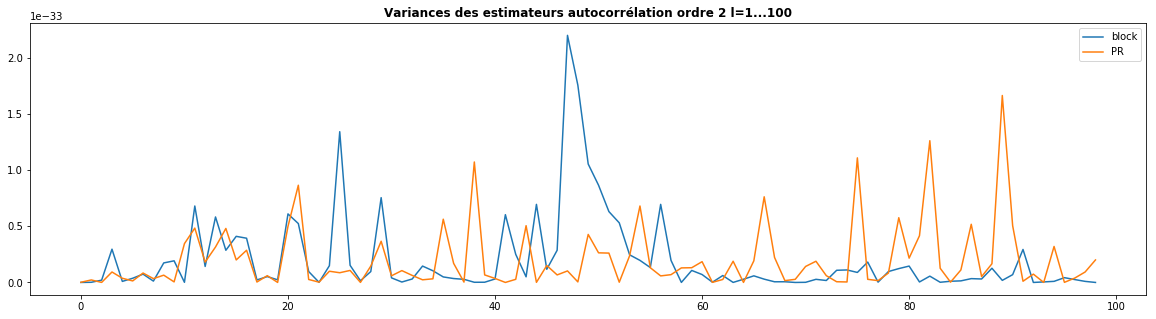

In [67]:
plt.figure(figsize=(20,5))
plt.title('Variances des estimateurs autocorrélation ordre 2 l=1...100',fontweight='bold')
plt.plot(list_var_block)
plt.plot(list_var_PR)
plt.legend(['block','PR'])
plt.show()

La variance du coefficient d'autocorrélation d'ordre 2 semble prendre occasionellement des valeurs élevées lorsque l augmente. En d'autres termes, lorsque la taille des blocs diminue, les coefficients bootstrapés se dispersent davantage. Cette observation est vraie pour les deux méthodes. On remarque cependant que lorsque l est proche de 100, la variance pour la méthode block prend des valeurs très élevées. Pour la méthode PR, on génère des blocs de taille aléatoire, ce qui permet des tailles de blocs parfois plus importantes et donc une variance réduite.

### Exercice 6

In [210]:
B=50
list_boot_sieve = bootstrap_sieve(ar1,B=B)
list_boot_block = bootstrap_block(l=5,serie=ar1,B=B)
list_boot_PR = bootstrap_PR(l=5,serie=ar1,B=B)

p_sieve=[]
p_block=[]
p_PR=[]
for i in range(B):
    #ordre p méthode Sieve
    ar1_model = armodel.AR(list_boot_sieve[i])
    p_sieve.append(ar1_model.select_order(maxlag=10,ic='aic'))
    #ordre p méthode block
    ar1_model = armodel.AR(list_boot_block[i])
    p_block.append(ar1_model.select_order(maxlag=10,ic='aic'))
    #ordre p méthode Sieve
    ar1_model = armodel.AR(list_boot_PR[i])
    p_PR.append(ar1_model.select_order(maxlag=10,ic='aic'))

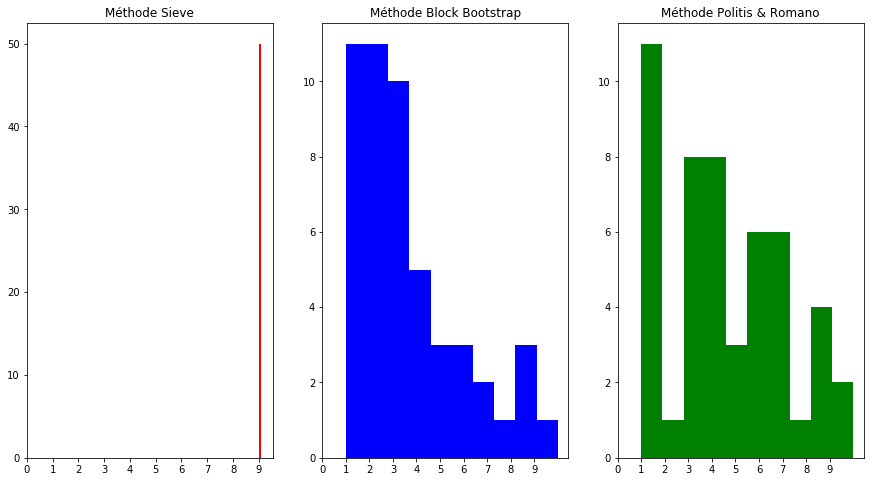

In [26]:
fig = plt.figure(figsize=(15,8))

plt.subplot(131)
plt.hist(p_sieve,color="red")
plt.title("Méthode Sieve")
plt.xticks(np.arange(0,10))
plt.subplot(132)
plt.hist(p_block,color="blue")
plt.title("Méthode Block Bootstrap")
plt.xticks(np.arange(0,10))
plt.subplot(133)
plt.hist(p_PR,color="green")
plt.title("Méthode Politis & Romano")
plt.xticks(np.arange(0,10))

plt.show()

Sur les 50 séries bootstrapés,  nous avons pour les méthodes 2 et 3 les ordres estimés qui semblent majoritairement préférer l'ordre 1 d'ajustement (même si d'autres ordres peuvent être également estimés). En revanche la première méthode n'offre qu'un ordre ajustement pour les 50 échantillons. Il n'admet aucune variabilité dans ses résultats. Nous pourrions associer ce résultat à un problème du type "biais-variance" : la méthode 1 estime le mauvais ordre avec certitude. 

### Exercice 7

Nous allons ici déterminer et comparer les intervalles de confiance percentile pour les deux types de simulation (AR(1) et MA(1)) pour les 4 méthodes de ré-échantillonage pour le coefficient d'auto-corellation d'ordre 2. Nous allons ensuite comparer les niveaux et puissances pour le test statistique $H_0 : \rho(2)=0$

#### Etude AR(1)

#####  1. Intervalles de confiance

In [26]:
def IC_perc(coef,B):
    alpha=0.05
    coef = sorted(coef)
    inter=[]
    inter.append(coef[math.ceil(B*(alpha/2))-1])
    inter.append(coef[math.ceil(B*(1-alpha/2))-1])
    return(inter)

In [27]:
def ICAN(serie):
    alpha=0.05
    ar1_model = armodel.AR(ar1)
    p=ar1_model.select_order(maxlag=10,ic='aic')
    fitted_ar1=ar1_model.fit(maxlag=p)
    beta = fitted_ar1.fittedvalues[1]
    std_beta = fitted_ar1.bse[0]
    A= []
    A.append(beta-std_beta/np.sqrt(len(serie))*norm.ppf(1-alpha/2))
    A.append(beta+std_beta/np.sqrt(len(serie))*norm.ppf(1-alpha/2))
    return(A)

In [28]:
B=100
listar_simple_sample = sample_iid(ar1,B=B)
listar_boots_sieve = bootstrap_sieve(ar1,B=B)
listar_boots_block = bootstrap_block(l=5,serie=ar1,B=B)
listar_boots_PR = bootstrap_PR(l=5,serie=ar1,B=B)

######  Méthode i.i.d Bootstrap

In [29]:
coef_list_iid = []
for b in range(B):
    sample = listar_simple_sample[b]
    ar1_model = armodel.AR(sample)
    #p=ar1_model.select_order(maxlag=10,ic='aic')
    fitted_ar1=ar1_model.fit(maxlag=1)
    coef_list_iid.append(stat_ts.acf(fitted_ar1.fittedvalues)[1])

######  Méthode Sieve

In [30]:
coef_list_sieve = []
for b in range(B):
    sample = listar_boot_sieve[b]
    ar1_model = armodel.AR(sample)
    #p=ar1_model.select_order(maxlag=10,ic='aic')
    fitted_ar1=ar1_model.fit(maxlag=1)
    coef_list_sieve.append(stat_ts.acf(fitted_ar1.fittedvalues)[1])

######  Méthode Block Bootstrap

In [31]:
coef_list_block = []
for b in range(B):
    sample = listar_boot_block[b]
    ar1_model = armodel.AR(sample)
    #p=ar1_model.select_order(maxlag=10,ic='aic')
    fitted_ar1=ar1_model.fit(maxlag=1)
    coef_list_block.append(stat_ts.acf(fitted_ar1.fittedvalues)[1])

######  Méthode Politis & Romano

In [32]:
coef_list_PR = []
for b in range(B):
    sample = listar_boot_PR[b]
    ar1_model = armodel.AR(sample)
    #p=ar1_model.select_order(maxlag=10,ic='aic')
    fitted_ar1=ar1_model.fit(maxlag=1)
    coef_list_PR.append(stat_ts.acf(fitted_ar1.fittedvalues)[1])

######  Comparaison des intervalles obtenus

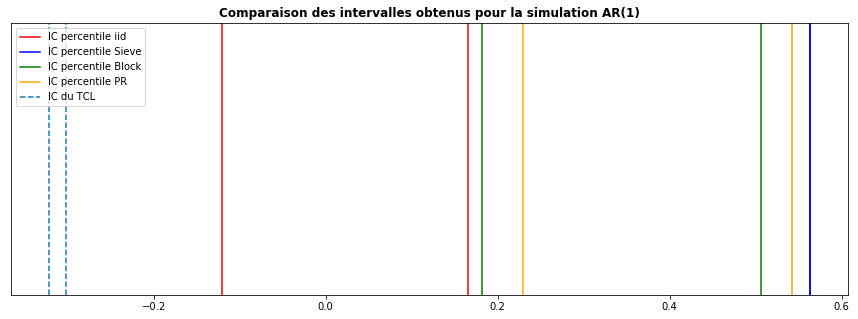

In [33]:
plt.figure(figsize=(15,5))
plt.title("Comparaison des intervalles obtenus pour la simulation AR(1)",fontweight='bold')
plt.axvline(x=IC_perc(coef_list_iid,B=100)[0] ,color="red",label="IC percentile iid")
plt.axvline(x=IC_perc(coef_list_iid,B=100)[1] ,color="red")
plt.axvline(x=IC_perc(coef_list_sieve,B=100)[0] ,color="blue",label="IC percentile Sieve")
plt.axvline(x=IC_perc(coef_list_sieve,B=100)[1] ,color="blue")
plt.axvline(x=IC_perc(coef_list_block,B=100)[0] ,color="green",label="IC percentile Block")
plt.axvline(x=IC_perc(coef_list_block,B=100)[1] ,color="green")
plt.axvline(x=IC_perc(coef_list_PR,B=100)[0] ,color="orange",label="IC percentile PR")
plt.axvline(x=IC_perc(coef_list_PR,B=100)[1] ,color="orange")
plt.axvline(x=ICAN(ar1)[0], linestyle="--",label="IC du TCL")
plt.axvline(x=ICAN(ar1)[1], linestyle="--")
plt.yticks([])
plt.legend()
plt.show()

Nos 4 méthodes de Bootstrap comprennent bien 0 dans leurs intervalles (puisque on cherche à "fiter" une série AR(1)). La méthode Sieve induit un intervalle de confiance beaucoup plus large que les autres. L'intervalle de confiance issue du TCL ne comprends pas 0. On constate donc ici l'intérêt des méthodes de Bootstrap étudiées.

##### 2. Test Statistique $ H_0 : \rho(2)=0$

#### Etude MA(1)

##### 1. Intervalles de confiance

In [34]:
B=100
listma_simple_sample = sample_iid(ma1,B=B)
listma_boots_sieve = bootstrap_sieve(ma1,B=B)
listma_boots_block = bootstrap_block(l=5,serie=ma1,B=B)
listma_boots_PR = bootstrap_PR(l=5,serie=ma1,B=B)

######  Méthode i.i.d Bootstrap

In [35]:
coef_list_iid_ma = []
for b in range(B):
    sample = listma_simple_sample[b]
    ma1_model = arima.ARMA(sample,order=(0,1))
    #p=ma1_model.k_ma
    fitted_ma1=ma1_model.fit(maxlag=1)
    coef_list_iid_ma.append(stat_ts.acf(fitted_ma1.fittedvalues)[1])

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


######  Méthode Sieve

In [36]:
coef_list_sieve_ma = []
for b in range(B):
    sample = listma_boots_sieve[b]
    ma1_model = arima.ARMA(sample,order=(0,1))
    #p=ma1_model.k_ma
    fitted_ma1=ma1_model.fit(maxlag=1)
    coef_list_sieve_ma.append(stat_ts.acf(fitted_ma1.fittedvalues)[1])

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


######  Méthode Block Bootstrap

In [37]:
coef_list_block_ma = []
for b in range(B):
    sample = listma_boots_block[b]
    ma1_model = arima.ARMA(sample,order=(0,1))
    #p=ma1_model.k_ma
    fitted_ma1=ma1_model.fit(maxlag=1)
    coef_list_block_ma.append(stat_ts.acf(fitted_ma1.fittedvalues)[1])

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


######  Méthode Politis & Romano

In [38]:
coef_list_PR_ma = []
for b in range(B):
    sample = listma_boots_PR[b]
    ma1_model = arima.ARMA(sample,order=(0,1))
    #p=ma1_model.k_ma
    fitted_ma1=ma1_model.fit(maxlag=1)
    coef_list_PR_ma.append(stat_ts.acf(fitted_ma1.fittedvalues)[1])

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


######  Comparaison des intervalles obtenus

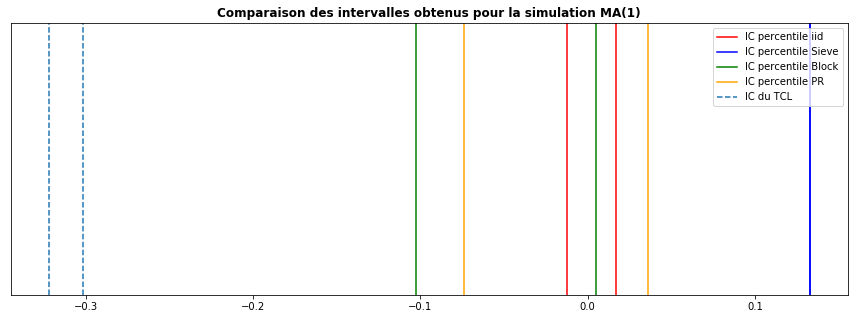

In [39]:
plt.figure(figsize=(15,5))
plt.title("Comparaison des intervalles obtenus pour la simulation MA(1)",fontweight='bold')
plt.axvline(x=IC_perc(coef_list_iid_ma,B=100)[0] ,color="red",label="IC percentile iid")
plt.axvline(x=IC_perc(coef_list_iid_ma,B=100)[1] ,color="red")
plt.axvline(x=IC_perc(coef_list_sieve_ma,B=100)[0] ,color="blue",label="IC percentile Sieve")
plt.axvline(x=IC_perc(coef_list_sieve_ma,B=100)[1] ,color="blue")
plt.axvline(x=IC_perc(coef_list_block_ma,B=100)[0] ,color="green",label="IC percentile Block")
plt.axvline(x=IC_perc(coef_list_block_ma,B=100)[1] ,color="green")
plt.axvline(x=IC_perc(coef_list_PR_ma,B=100)[0] ,color="orange",label="IC percentile PR")
plt.axvline(x=IC_perc(coef_list_PR_ma,B=100)[1] ,color="orange")
plt.axvline(x=ICAN(ma1)[0], linestyle="--",label="IC du TCL")
plt.axvline(x=ICAN(ma1)[1], linestyle="--")
plt.yticks([])
plt.legend()
plt.show()

#####  2. Test Statistique $ H_0 : \rho(2)=0$

In [40]:
# Mise en place de l'AR(1)
n=200
epsilon = np.random.exponential(1,n)-1
phis=np.array([-0.6])
p=1
ar1 = AR_sim(p,phis,epsilon)

In [41]:
listar_boot_sieve = bootstrap_sieve(ar1,B=B)
listar_boot_block = bootstrap_block(l=5,serie=ar1,B=B)
listar_boot_PR = bootstrap_PR(l=5,serie=ar1,B=B)
listar_simple_sample = sample_iid(ar1,B=B)

In [42]:
S_bar_sieve=[]
S_bar_block=[]
S_bar_PR=[]
S_bar_iid=[]

n=len(ar1)
fitted_init = armodel.AR(ar1).fit(max_order=1).fittedvalues
S_bar = stat_ts.acf(fitted_init)[2]

for b in range(B):
    #fit les modèles pour chaque méthode
    ma_model_sieve = armodel.AR(listar_boot_sieve[b])
    ma_model_block = armodel.AR(listar_boot_block[b])
    ma_model_PR = armodel.AR(listar_boot_PR[b])
    ma_model_iid = armodel.AR(listar_simple_sample[b])
    #calcule les fitted values
    fitted_sieve = ma_model_sieve.fit(max_order=1).fittedvalues
    fitted_block = ma_model_block.fit(max_order=1).fittedvalues
    fitted_PR = ma_model_PR.fit(max_order=1).fittedvalues
    fitted_iid = ma_model_iid.fit(max_order=1).fittedvalues
    #calcule les stat S
    S_bar_sieve.append(stat_ts.acf(fitted_sieve)[2])
    S_bar_block.append(stat_ts.acf(fitted_block)[2])
    S_bar_PR.append(stat_ts.acf(fitted_PR)[2])
    S_bar_iid.append(stat_ts.acf(fitted_iid)[2])

p_boot_sieve = (len([x for x in S_bar_sieve if x>S_bar])+1)/(B+1)
p_boot_block = (len([x for x in S_bar_block if x>S_bar])+1)/(B+1)
p_boot_PR = (len([x for x in S_bar_PR if x>S_bar])+1)/(B+1)
p_boot_iid = (len([x for x in S_bar_iid if x>S_bar])+1)/(B+1)

print(p_boot_sieve)
print(p_boot_block)
print(p_boot_PR)
print(p_boot_iid)

0.009900990099009901
0.0297029702970297
0.18811881188118812
0.10891089108910891


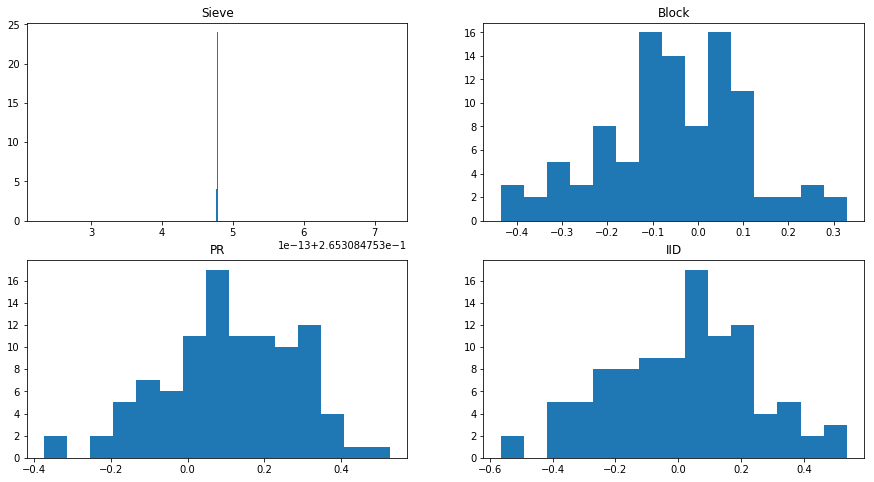

In [43]:
list_pvalue_sieve=[]
list_pvalue_block=[]
list_pvalue_PR=[]
list_pvalue_iid=[]

n=len(ar1)

for b in range(B):
    ma_model_sieve = armodel.AR(listar_boot_sieve[b])
    ma_model_block = armodel.AR(listar_boot_block[b])
    ma_model_PR = armodel.AR(listar_boot_PR[b])
    ma_model_iid = armodel.AR(listar_simple_sample[b])
    list_pvalue_sieve.append(stat_ts.acf(ma_model_sieve.fit(max_order=1).fittedvalues)[2])
    list_pvalue_block.append(stat_ts.acf(ma_model_block.fit(max_order=1).fittedvalues)[2])
    list_pvalue_PR.append(stat_ts.acf(ma_model_PR.fit(max_order=1).fittedvalues)[2])
    list_pvalue_iid.append(stat_ts.acf(ma_model_iid.fit(max_order=1).fittedvalues)[2])

plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(list_pvalue_sieve,bins=15)
plt.title('Sieve')
plt.subplot(222)
plt.hist(list_pvalue_block,bins=15)
plt.title('Block')
plt.subplot(223)
plt.hist(list_pvalue_PR,bins=15)
plt.title('PR')
plt.subplot(224)
plt.hist(list_pvalue_iid,bins=15)
plt.title('IID')
plt.show()

#### MA(1)

In [49]:
# Mise en place du MA(1)
n=200
epsilon = np.random.exponential(1,n)-1
q=1
psis=np.array([0.5])
ma1=MA_sim(q,psis,epsilon)

In [50]:
listma_boot_sieve = bootstrap_sieve(ma1,B=B)
listma_boot_block = bootstrap_block(l=5,serie=ma1,B=B)
listma_boot_PR = bootstrap_PR(l=5,serie=ma1,B=B)
listma_simple_sample = sample_iid(ma1,B=B)

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


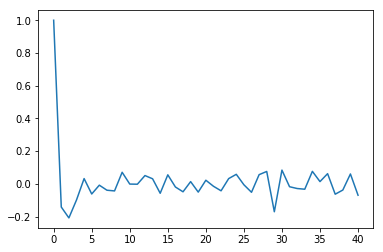

In [46]:
ma_model = arima.ARIMA(ar1,order=(1,1,0))
ma_fitted = ma_model.fit().fittedvalues
plt.plot(stat_ts.acf(ma_fitted))
plt.show()

#### méthode p_values

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrele

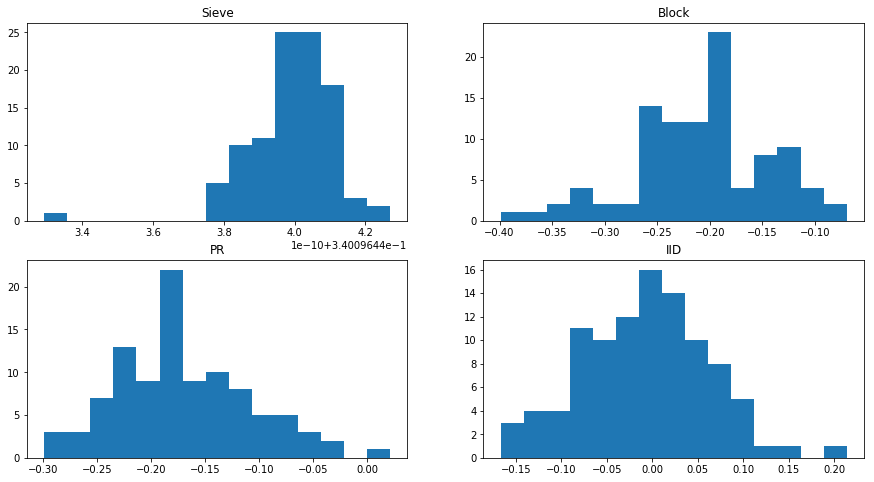

In [47]:
list_pvalue_sieve=[]
list_pvalue_block=[]
list_pvalue_PR=[]
list_pvalue_iid=[]

n=len(ma1)

for b in range(B):
    #fit les modèles pour chaque méthode
    ma_model_sieve = arima.ARIMA(listma_boot_sieve[b],order=(0,1,1))
    ma_model_block = arima.ARIMA(listma_boot_block[b],order=(0,1,1))
    ma_model_PR = arima.ARIMA(listma_boot_PR[b],order=(0,1,1))
    ma_model_iid = arima.ARIMA(listma_simple_sample[b],order=(0,1,1))
    list_pvalue_sieve.append(stat_ts.acf(ma_model_sieve.fit(max_order=1).fittedvalues)[2])
    list_pvalue_block.append(stat_ts.acf(ma_model_block.fit(max_order=1).fittedvalues)[2])
    list_pvalue_PR.append(stat_ts.acf(ma_model_PR.fit(max_order=1).fittedvalues)[2])
    list_pvalue_iid.append(stat_ts.acf(ma_model_iid.fit(max_order=1).fittedvalues)[2])

plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(list_pvalue_sieve,bins=15)
plt.title('Sieve')
plt.subplot(222)
plt.hist(list_pvalue_block,bins=15)
plt.title('Block')
plt.subplot(223)
plt.hist(list_pvalue_PR,bins=15)
plt.title('PR')
plt.subplot(224)
plt.hist(list_pvalue_iid,bins=15)
plt.title('IID')
plt.show()

#### méthode t-bootstrap

In [51]:
S_bar_sieve=[]
S_bar_block=[]
S_bar_PR=[]
S_bar_iid=[]

n=len(ma1)
fitted_init = arima.ARIMA(ma1,order=(0,1,1)).fit(max_order=1).fittedvalues
S_bar =stat_ts.acf(fitted_init)[2]

for b in range(B):
    #fit les modèles pour chaque méthode
    ma_model_sieve = arima.ARIMA(listma_boot_sieve[b],order=(0,1,1))
    ma_model_block = arima.ARIMA(listma_boot_block[b],order=(0,1,1))
    ma_model_PR = arima.ARIMA(listma_boot_PR[b],order=(0,1,1))
    ma_model_iid = arima.ARIMA(listma_simple_sample[b],order=(0,1,1))
    #calcule les fitted values
    fitted_sieve = ma_model_sieve.fit(max_order=1).fittedvalues
    fitted_block = ma_model_block.fit(max_order=1).fittedvalues
    fitted_PR = ma_model_PR.fit(max_order=1).fittedvalues
    fitted_iid = ma_model_iid.fit(max_order=1).fittedvalues
    #calcule les stat S
    S_bar_sieve.append(stat_ts.acf(fitted_sieve)[2])
    S_bar_block.append(stat_ts.acf(fitted_block)[2])
    S_bar_PR.append(stat_ts.acf(fitted_PR)[2])
    S_bar_iid.append(stat_ts.acf(fitted_iid)[2])

p_boot_sieve = (len([x for x in S_bar_sieve if x>S_bar])+1)/(B+1)
p_boot_block = (len([x for x in S_bar_block if x>S_bar])+1)/(B+1)
p_boot_PR = (len([x for x in S_bar_PR if x>S_bar])+1)/(B+1)
p_boot_iid = (len([x for x in S_bar_iid if x>S_bar])+1)/(B+1)

print(p_boot_sieve)
print(p_boot_block)
print(p_boot_PR)
print(p_boot_iid)

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/antoinegrele

1.0
0.8910891089108911
0.8217821782178217
1.0
